In [35]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as msno 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler




In [3]:
target_column = 'total_upcoming_points'

In [4]:
df = pd.read_csv('./cleaned_merged_seasons.csv')  
df.head()

/var/folders/m0/m60fjz952_l28k4w5jsnj12h0000gn/T/ipykernel_15417/3640293773.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./cleaned_merged_seasons.csv')


,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,...,2.0,0.0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,...,1.0,0.0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,...,3.0,23.0,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,...,1.0,0.0,0,0,0,0,50,False,0,1
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,...,1.0,0.0,1,0,0,0,45,True,1,1


In [5]:
print(df.columns.tolist())

['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW']


In [6]:
df.shape

(96169, 37)

| Column | Meaning |
|--------|----------|
| **season_x** | The Premier League season (e.g., `2023/24`). |
| **name** | Player’s full name. |
| **position** | Player’s role on the pitch — `GK`, `DEF`, `MID`, or `FWD`. |
| **team_x** | Player’s real-life club (e.g., “Liverpool”). |
| **assists** | Number of assists by the player in that match. |
| **bonus** | Bonus points earned (1–3 points based on the BPS system). |
| **bps** | “Bonus Point System” raw score — used to determine who gets the `bonus` points. |
| **clean_sheets** | 1 if the team conceded **0 goals** while the player was on the pitch (for GKs and DEFs mainly). |
| **creativity** | FPL metric estimating how creative a player was — based on key passes, chances created, etc. |
| **element** | Internal player ID (used in FPL API, not meaningful by itself). |
| **fixture** | Fixture ID — links to which match this row corresponds to. |
| **goals_conceded** | Number of goals conceded by the player’s team during that match (when he was on the field). |
| **goals_scored** | Number of goals the player scored in that match. |
| **ict_index** | FPL composite stat combining **Influence + Creativity + Threat** — an overall activity rating. |
| **influence** | Measures impact on the match (goals, assists, defensive actions, etc.). |
| **kickoff_time** | Date and time of the match kickoff (UTC). |
| **minutes** | Number of minutes the player played in that match. |
| **opponent_team** | ID of the opposing team (numeric). |
| **opp_team_name** | Name of the opposing team (string, more readable). |
| **own_goals** | Number of own goals scored by the player. |
| **penalties_missed** | How many penalties the player missed in that match. |
| **penalties_saved** | For goalkeepers — number of penalties saved. |
| **red_cards** | Number of red cards received in that match (0 or 1). |
| **round** | The gameweek number (1–38). |
| **saves** | For goalkeepers — number of shots saved. |
| **selected** | Number of FPL managers who had selected this player in their teams before that gameweek. |
| **team_a_score** | Goals scored by the **away** team in that fixture. |
| **team_h_score** | Goals scored by the **home** team in that fixture. |
| **threat** | FPL stat measuring how likely a player was to score (based on shots, touches in box, etc.). |
| **total_points** | Player’s total FPL points from that match (main performance indicator). |
| **transfers_balance** | Net transfers (transfers_in − transfers_out) that week. |
| **transfers_in** | How many FPL managers transferred this player **into** their team that week. |
| **transfers_out** | How many FPL managers transferred this player **out** that week. |
| **value** | Player’s FPL price that gameweek (in tenths of a million, e.g. 75 = £7.5M). |
| **was_home** | `True` if the player’s team played **at home**, `False` if **away**. |
| **yellow_cards** | Number of yellow cards received in that match. |
| **GW** | Gameweek label or number (same as `round`, sometimes kept separately). |

In [7]:
isnull = df.isnull().sum()
isnull[isnull>0]

team_x    19852
dtype: int64

In [8]:
df['team_x'].tail(20)

96149       Aston Villa
96150          West Ham
96151             Spurs
96152           Arsenal
96153            Wolves
96154         Brentford
96155           Man Utd
96156           Arsenal
96157            Wolves
96158    Crystal Palace
96159         Leicester
96160           Everton
96161         Leicester
96162             Spurs
96163         Newcastle
96164             Spurs
96165             Spurs
96166       Aston Villa
96167          Brighton
96168       Bournemouth
Name: team_x, dtype: object

In [9]:
teamModeForEachPlayer = df.groupby('name')['team_x'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None)
df['team_x'] = df.apply(lambda row:  teamModeForEachPlayer[row['name']] if pd.isna(row['team_x']) else row['team_x'],axis=1)

In [10]:
isnull = df.isnull().sum()
isnull[isnull>0]

Series([], dtype: int64)

In [11]:
df.duplicated().sum()

np.int64(0)

## Unnecessary columns:


In [12]:
print(df.columns.tolist())

['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW']


In [13]:
df['kickoff_time'].head()

0    2016-08-15T19:00:00Z
1    2016-08-13T14:00:00Z
2    2016-08-14T15:00:00Z
3    2016-08-13T14:00:00Z
4    2016-08-13T14:00:00Z
Name: kickoff_time, dtype: object

In [14]:
# element is the id of the player, may be related to the bps
# take care of this: element=>player_id, fixure=>match_id
# ict_index = influence + creativity + threat, may be redundant or the others are 
# is bps to be removed?
# are minutes played by the player really important?
#'team_a_score', 'team_h_score', 
to_drop_columns = ['season_x', 'element','name', 'team_x', 'kickoff_time', 'minutes', 'opponent_team', 'opp_team_name', 'round', 'selected',  'transfers_balance', 'transfers_in', 'transfers_out', 'GW']


In [15]:
df = df.sort_values(by=['name', 'GW'])

df['form'] = df.groupby('name')['total_points'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)
df['form'] = df['form']/10

print(df.form)

19852    0.100
44691    0.050
20277    0.300
45255    0.250
20816    0.275
         ...  
41483    0.000
41484    0.000
42382    0.000
42997    0.000
43705    0.000
Name: form, Length: 96169, dtype: float64


## data engineering



In [16]:
df['form'][df.form==0].count()

np.int64(28003)

In [17]:
pos_summary = (
    df.groupby(['season_x', 'position'])['total_points']
      .sum()
      .reset_index()
)

# Then find average total points per position across seasons
avg_points_by_position = (
    pos_summary.groupby('position')['total_points']
    .mean()
    .sort_values(ascending=False)
)

print(avg_points_by_position)

position
MID    11384.4
DEF     8705.2
FWD     3975.8
GK      2448.8
GKP       72.0
Name: total_points, dtype: float64


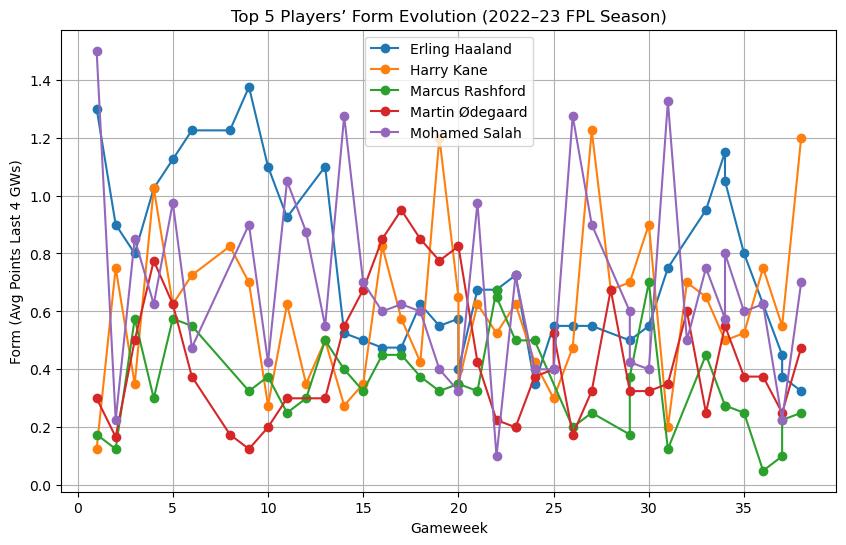

In [18]:
season_2223 = df[df['season_x'] == '2022-23']

top5_players = (
    season_2223.groupby('name')['total_points']
    .sum()
    .nlargest(5)
    .index
)

top5_df = season_2223[season_2223['name'].isin(top5_players)]

plt.figure(figsize=(10,6))
for name, group in top5_df.groupby('name'):
    plt.plot(group['GW'], group['form'], marker='o', label=name)

plt.title('Top 5 Players’ Form Evolution (2022–23 FPL Season)')
plt.xlabel('Gameweek')
plt.ylabel('Form (Avg Points Last 4 GWs)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
latest_gw = season_2223['GW'].max()
top_in_form = (
    season_2223[season_2223['GW'] == latest_gw]
    .nlargest(5, 'form')['name']
)

print("Top 5 players by total points:", list(top5_players))
print("Top 5 players by form in last GW:", list(top_in_form))

Top 5 players by total points: ['Erling Haaland', 'Harry Kane', 'Mohamed Salah', 'Martin Ødegaard', 'Marcus Rashford']
Top 5 players by form in last GW: ['Harry Kane', 'Taiwo Awoniyi', 'Jamie Vardy', 'Andrew Robertson', 'Yoane Wissa']


In [20]:
df = df.sort_values(['name', 'GW'])
df[target_column] = df.groupby('name')['total_points'].shift(-1)

In [21]:
df.dropna(inplace=True)

In [22]:
df.shape

(94842, 39)

In [23]:
df.position = df.position.apply(lambda x: 'GK' if x == 'GKP' else x)

In [24]:
df_clean = df.drop(columns=to_drop_columns,)

In [25]:
df_clean.columns

Index(['position', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'saves', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'value', 'was_home', 'yellow_cards', 'form', 'total_upcoming_points'],
      dtype='object')

In [26]:
position_dummies = pd.get_dummies(df_clean['position'], drop_first=True)
df_clean = pd.concat([df_clean, position_dummies], axis=1)
df_clean = df_clean.drop(columns=['position'])
df.columns

Index(['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'selected',
       'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW', 'form', 'total_upcoming_points'],
      dtype='object')

In [27]:
df.dtypes

season_x                  object
name                      object
position                  object
team_x                    object
assists                    int64
bonus                      int64
bps                        int64
clean_sheets               int64
creativity               float64
element                    int64
fixture                    int64
goals_conceded             int64
goals_scored               int64
ict_index                float64
influence                float64
kickoff_time              object
minutes                    int64
opponent_team              int64
opp_team_name             object
own_goals                  int64
penalties_missed           int64
penalties_saved            int64
red_cards                  int64
round                      int64
saves                      int64
selected                   int64
team_a_score             float64
team_h_score             float64
threat                   float64
total_points               int64
transfers_

In [28]:

def plot_feature_target_corr(df, target_column, top_n=None):
    
    
    corr = df.corr()[target_column].drop(target_column).sort_values(ascending=False)
    
    if top_n:
        corr = corr.head(top_n)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=corr.values, y=corr.index, palette='coolwarm')
    plt.title(f"Feature Correlation with Target: '{target_column}'", fontsize=14)
    plt.xlabel("Correlation Coefficient", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

/var/folders/m0/m60fjz952_l28k4w5jsnj12h0000gn/T/ipykernel_15417/2236581390.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette='coolwarm')


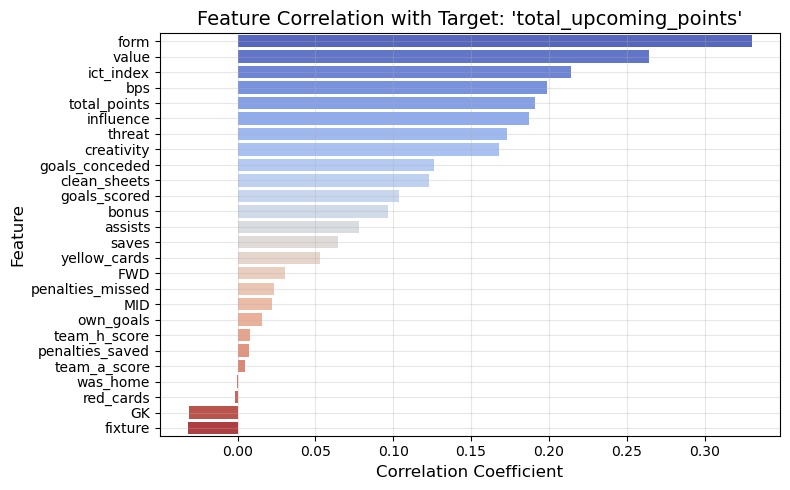

In [29]:
plot_feature_target_corr(df_clean, target_column)

In [30]:
df_clean.dtypes

assists                    int64
bonus                      int64
bps                        int64
clean_sheets               int64
creativity               float64
fixture                    int64
goals_conceded             int64
goals_scored               int64
ict_index                float64
influence                float64
own_goals                  int64
penalties_missed           int64
penalties_saved            int64
red_cards                  int64
saves                      int64
team_a_score             float64
team_h_score             float64
threat                   float64
total_points               int64
value                      int64
was_home                    bool
yellow_cards               int64
form                     float64
total_upcoming_points    float64
FWD                         bool
GK                          bool
MID                         bool
dtype: object

In [31]:


def plot_fitting_line(y_true, y_pred, model_name):

    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y_true, y=y_pred, color='blue', alpha=0.6, label='Predictions')
    
    max_val = max(np.max(y_true), np.max(y_pred))
    min_val = min(np.min(y_true), np.min(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Fit')
    
    sns.regplot(x=y_true, y=y_pred, scatter=False, color='green', line_kws={'label': 'Fit Line'})
    
    plt.title(f"{model_name} — Actual vs Predicted", fontsize=14)
    plt.xlabel("Actual Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [44]:
def plot_fitting_and_print_metrics(y_test,y_pred, model_name):
    plot_fitting_line(y_test, y_pred, model_name)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = np.nanmean(np.abs((y_test - y_pred) / np.where(y_test == 0, np.nan, y_test))) * 100    
    print("✅ Model trained successfully!")
    print("📊 Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE):      {mae:.4f}")
    print(f"Mean Squared Error (MSE):       {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-squared (R²):                 {r2:.4f}")

In [40]:


def model_xgboost(df):

    df = df.copy()
    
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    plot_fitting_and_print_metrics(y_test, y_pred, "XGBoost Regressor")
    
  
    
    return model

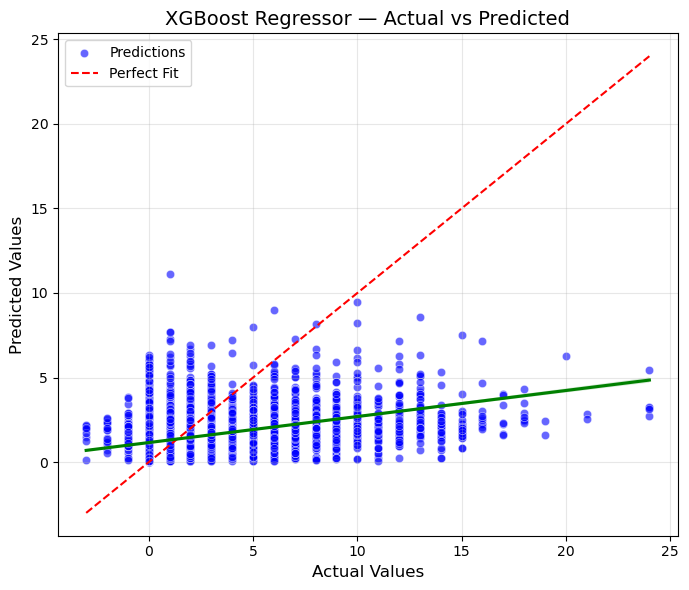

✅ Model trained successfully!
📊 Evaluation Metrics:
Mean Absolute Error (MAE):      1.4029
Mean Squared Error (MSE):       5.4463
Root Mean Squared Error (RMSE): 2.3337
Mean Absolute Percentage Error (MAPE): 60.96%
R-squared (R²):                 0.1523


In [45]:
model = model_xgboost(df_clean)

In [46]:
def model_dnn(df, target_column):
    df = df.copy()
    
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Define the DNN model
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # output layer for regression
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=0
    )
    
    y_pred = model.predict(X_test).flatten()
    
    plot_fitting_and_print_metrics(y_test, y_pred, "Deep Neural Network Regressor")
    
    return model, scaler

/Users/macbook/miniforge3/envs/ml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


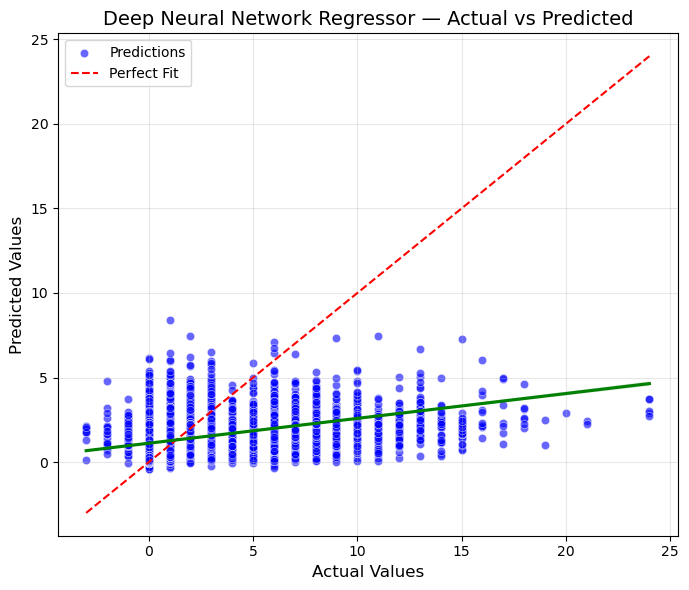

✅ Model trained successfully!
📊 Evaluation Metrics:
Mean Absolute Error (MAE):      1.3937
Mean Squared Error (MSE):       5.5126
Root Mean Squared Error (RMSE): 2.3479
Mean Absolute Percentage Error (MAPE): 61.70%
R-squared (R²):                 0.1420


In [47]:
model_dnn, scaler = model_dnn(df_clean, target_column)